In [121]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize


In [122]:
model = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'

In [123]:
model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0


In [124]:
met_list = []
for m in model.metabolites:
    if '__L_c' in m.id:
        met_list.append(m)
met_list += [model.metabolites.get_by_id(x) for x in ['ac_c', 'glc__D_c', 'cit_c']]

cs_list = ['EX_glc__D_e', "EX_glu__L_e", "EX_ac_e", "EX_cit_e", "EX_ala__L_e"]

model.reactions.EX_glc__D_e.lower_bound = 0

result_list = []
for cs in cs_list:
    for m in met_list:
        with model:
            r_ex = model.reactions.get_by_id(cs)
            r_ex.lower_bound = -1000
            m_ex,_ = r_ex.metabolites.popitem()
            
            model.reactions.ATPM.lower_bound = 0
            r_dm = model.add_boundary(m, 'demand')
            r_dm.lower_bound = 1
            model.reactions.ER_pool_TG_.objective_coefficient = 1
            model.objective_direction = 'min'
            
            result_list.append([m_ex.name, m.name, model.slim_optimize()])


In [125]:
df = pd.DataFrame(result_list, columns = ["Carbon source", "Target metabolite", "Required proteome"])

In [126]:
df_w = df.pivot(index="Carbon source", columns="Target metabolite", values="Required proteome")

In [127]:
df_w.isna().shape


(5, 44)

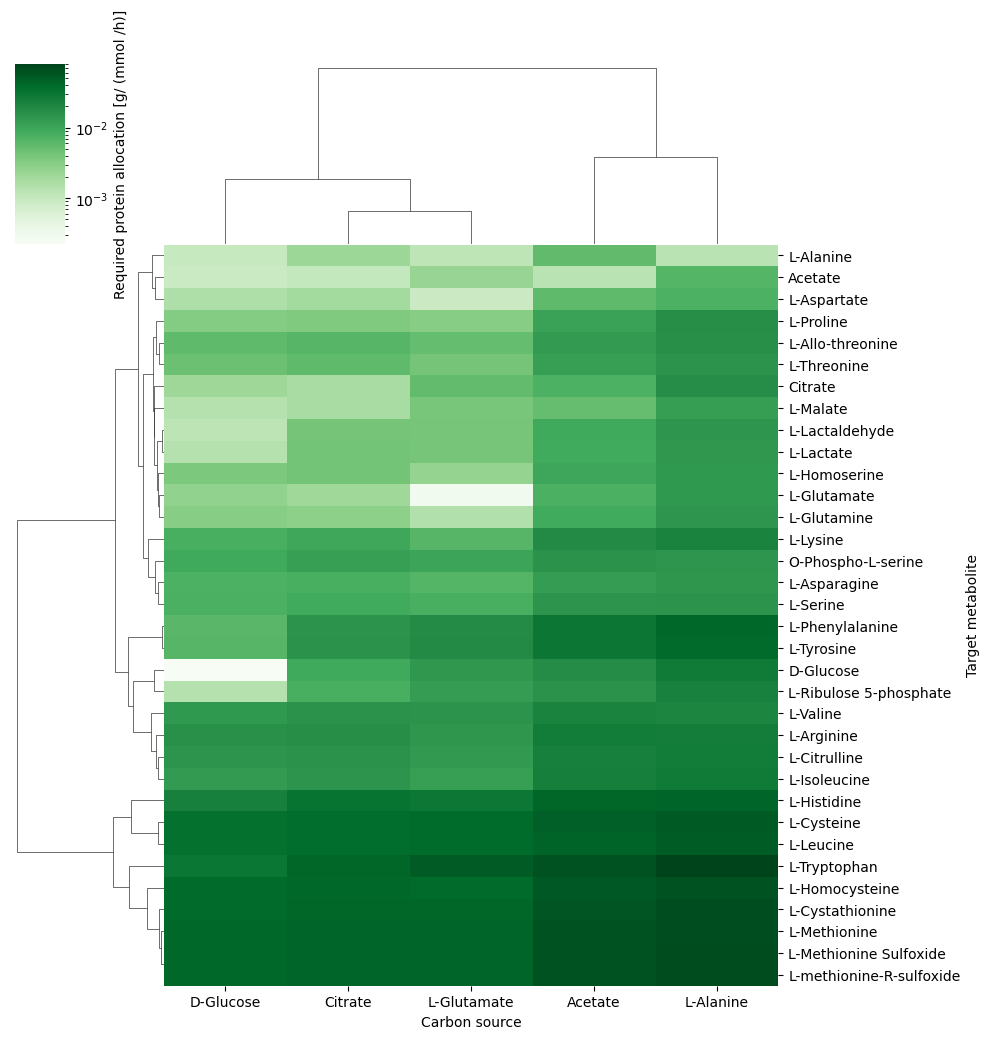

In [128]:
# df_plot = df_w.replace(np.nan, 0)
df_plot = df_w.loc[:, ~df_w.isna().any()]
ax = sns.clustermap(data=df_plot.T, yticklabels = True, norm=LogNorm(), cmap = 'Greens',
                   cbar_kws={'label': r"Required protein allocation [g/ (mmol /h)]"})

plt.savefig('example_protein_allocation_requirement.png')

In [129]:
df_w.isna().any()

Target metabolite
Acetate                     False
Citrate                     False
D-Glucose                   False
L-Alanine                   False
L-Allo-threonine            False
L-Arabinose                  True
L-Arginine                  False
L-Asparagine                False
L-Aspartate                 False
L-Citrulline                False
L-Cystathionine             False
L-Cysteine                  False
L-Fucose                     True
L-Galactonate                True
L-Glutamate                 False
L-Glutamine                 False
L-Histidine                 False
L-Homocysteine              False
L-Homoserine                False
L-Idonate                    True
L-Isoleucine                False
L-Lactaldehyde              False
L-Lactate                   False
L-Leucine                   False
L-Lysine                    False
L-Lyxose                     True
L-Malate                    False
L-Methionine                False
L-Methionine Sulfoxide      Fa

In [44]:
sns.clustermap?

Signature:
sns.clustermap(
    data,
    *,
    pivot_kws=None,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
    figsize=(10, 10),
    cbar_kws=None,
    row_cluster=True,
    col_cluster=True,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=None,
    mask=None,
    dendrogram_ratio=0.2,
    colors_ratio=0.03,
    cbar_pos=(0.02, 0.8, 0.05, 0.18),
    tree_kws=None,
    **kwargs,
)
Docstring:
Plot a matrix dataset as a hierarchically-clustered heatmap.

Parameters
----------
data : 2D array-like
    Rectangular data for clustering. Cannot contain NAs.
pivot_kws : dict, optional
    If `data` is a tidy dataframe, can provide keyword arguments for
    pivot to create a rectangular dataframe.
method : str, optional
    Linkage method to use for calculating clusters. See
    :func:`scipy.cluster.hierarchy.linkage` documentation for more
    information.
metric : str, optional
    Distance metric to use for the data